# **AhR agonist prediction_Data curation**

**Curate the 'in house' dataset from our group**

In [ ]:
# Set up working directory
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='darkgrid')

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# to restrict the float value to 3 dcimal places
pd.set_option('display.float_format',lambda x:'%.3f'%x)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
## After installing rdkit and mordred, it needs to restart the session to use the old version of numpy
## Package version matters
!pip install rdkit  ##version 2024.9.6
#!pip install xlsxwriter
!pip install mordred ##version 1.2.0
# import Chemoinformatic libraries
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw, PandasTools
from rdkit import DataStructs

## **Data curation**

In [ ]:
#load in_house_dataset (ihd)
ihd = pd.read_excel('/content/drive/MyDrive/AhR/Raw dataset/2022_03_14_Mastersheet Bioassays_incl_SHSY5Y_vs2.xlsx')

# keep certain columns
ihd = ihd[['CASRN', 'Chemical name', 'AhR IC10 (Exp) (M)', 'SE_AhR_IC10', 'AhR EC10 (Exp) (M)','SE_AhR_EC10','Source_AhR (Exp)']]

# remove chemicals without values in the column 'AhR EC10' & chemicals without CASRN
ihd = ihd.dropna(subset ='AhR EC10 (Exp) (M)', axis = 0)
ihd = ihd.dropna(subset ='CASRN', axis = 0)

## remove data entries from Tox21

df = ihd[ihd['Source_AhR (Exp)'] != 'Tox21']

# Function to determine the label according to the value in the column 'Confidence'
def label(x):
    if x == 'not active':
        return '0' #inactive
    else:
        return '1' #active
#create a column for labels and assign values
df['Label'] = df['AhR EC10 (Exp) (M)'].apply(label)

In [ ]:
#load an csv file into a dataframe using Pandas, from Georg
##training_dataset_classfication (tdc) after curating evaluated Tox21 dataset
tdc = pd.read_csv('/content/drive/MyDrive/AhR/06/Training_dataset_classification.csv')
##training_dataset_regression (tdr) after curating evaluated Tox21 dataset
##tdr = pd.read_csv('/content/drive/MyDrive/AhR/06/Training_dataset_regression.csv')
#uncertain_dataset = pd.read_csv('/content/drive/MyDrive/AhR/06/In_house_test_dataset.csv', index_col=0)

tdc_update = pd.read_csv('/content/drive/MyDrive/AhR/10_finalize/Training_data_classification_selected_descriptors_scaled.csv', index_col=0)


# get the CASRN of intersection for training dataset for classificaiton with in_house dataset
remove_index = list(set(df['CASRN'].to_list()).intersection(set(tdc_update.index.to_list())))
df = df[~df['CASRN'].isin(remove_index)]

In [ ]:
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

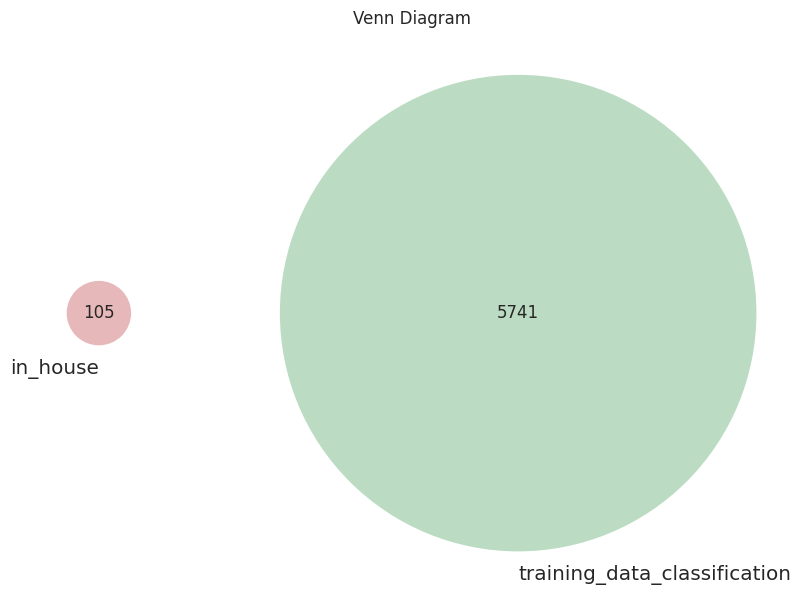

In [ ]:
# show intersection between in house dataset and training dataset for classification
plt.figure(figsize=(10,10))
plt.title("Venn Diagram")

venn2([set(df['CASRN'].to_list()),
       set(tdc['CASRN'].to_list())],
       set_labels=('in_house', 'training_data_classification')
     )

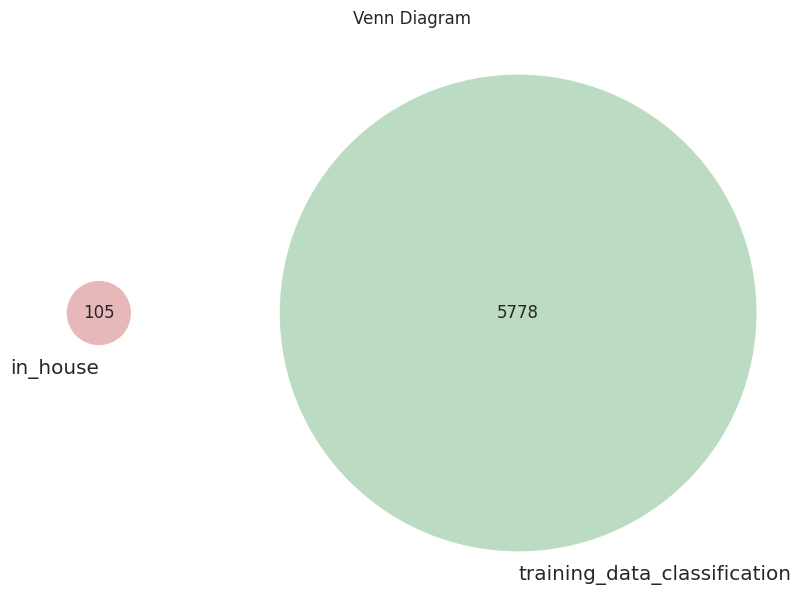

In [ ]:
# show intersection between in house dataset and training dataset for classification with updated structures
plt.figure(figsize=(10,10))
plt.title("Venn Diagram")

venn2([set(df['CASRN'].to_list()),
       set(tdc_update.index.to_list())],
       set_labels=('in_house', 'training_data_classification')
     )

In [ ]:
ihd_Active = df[df['Label'] == '1']
ihd_Inactive = df[df['Label'] == '0']

ihd_Active['AhR EC10 (Exp) (M)'] = ihd_Active['AhR EC10 (Exp) (M)'].astype(float)
ihd_Active_filter = ihd_Active[ihd_Active['AhR IC10 (Exp) (M)'] != 'no cytotoxicity']
ihd_Active_filter['AhR IC10 (Exp) (M)'] = ihd_Active_filter['AhR IC10 (Exp) (M)'].astype(float)

ihd_Active_filter['SR'] =  ihd_Active_filter['AhR IC10 (Exp) (M)'] / ihd_Active_filter['AhR EC10 (Exp) (M)']
ihd_Active_filter['AhR EC10 (Exp) (M)'] = ihd_Active['AhR EC10 (Exp) (M)'].apply(lambda x: "{:.2e}".format(x))


df_low_specificity = ihd_Active_filter[ihd_Active_filter['SR'] < 10]
#df_low_specificity.to_csv('In_house_low_specificity.csv', index = False)

low_specificity_list = df_low_specificity['CASRN'].tolist()
with_SE_IC10_list = ihd_Inactive[~ihd_Inactive['SE_AhR_IC10'].isna()]['CASRN'].tolist()

remove_list = low_specificity_list + with_SE_IC10_list
#remove structures with low specificity (SR < 10) and with SE_AhR_IC10 values
df_filter = df[~df['CASRN'].isin(remove_list)]


df_filter = df_filter.reset_index(drop=True)

In [ ]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CASRN               64 non-null     object 
 1   Chemical name       64 non-null     object 
 2   AhR IC10 (Exp) (M)  64 non-null     object 
 3   SE_AhR_IC10         6 non-null      float64
 4   AhR EC10 (Exp) (M)  64 non-null     object 
 5   SE_AhR_EC10         8 non-null      float64
 6   Source_AhR (Exp)    64 non-null     object 
 7   Label               64 non-null     object 
dtypes: float64(2), object(6)
memory usage: 4.1+ KB


In [ ]:
# append CID to the list from previous dataset
df_filter.to_csv('in_house_high_speicficity.csv')

## **Retrieve CID and import 3D sdf**

In [ ]:
!pip install pubchempy

  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13819 sha256=c887d22f2c834303bd3a2c94f6fa6c73c2a2fc740b2ee5a4c5132558d60ba06f
  Stored in directory: /root/.cache/pip/wheels/8b/e3/6c/3385b2db08b0985a87f5b117f98d0cb61a3ae3ca3bcbbd8307
Successfully built pubchempy


In [ ]:
import pubchempy as pcp

In [ ]:
def search_pubchem(compound: str) -> int:
    """Search PubChem for a given compound and return its CID."""
    try:
        result = pcp.get_compounds(compound, 'name', record_type='2d')[0]
        return result.cid
    except (IndexError, pcp.PubChemHTTPError) as e:
        print(f"Error searching PubChem for {compound}: {e}")
        return None

In [ ]:
 # Loop through DataFrame and search PubChem for each compound
cids = []
for index, row in in_house.iterrows():
    compound_name = row['Chemical name']
    cid = search_pubchem(compound_name)
    cids.append(cid)
in_house['CID'] = cids
    #print(cids)

Error searching PubChem for 2H-1-Benzopyran-2-one, 7-amino-4-methyl- (7-Amino-4-methylcoumarin): 'PUGREST.ServerBusy'
Error searching PubChem for Acrinathrin: 'PUGREST.ServerBusy'
Error searching PubChem for beta-Endosulfan: 'PUGREST.ServerBusy'
Error searching PubChem for PCB-11: list index out of range
Error searching PubChem for PCB-2: list index out of range
Error searching PubChem for Methoxychlor (p,p'-Dimethoxydiphenyltrichloroethane): list index out of range
Error searching PubChem for Mesotrione: 'PUGREST.ServerBusy'
Error searching PubChem for Genistein: 'PUGREST.ServerBusy'
Error searching PubChem for Ethofumesate: 'PUGREST.ServerBusy'
Error searching PubChem for Erythromycin: 'PUGREST.ServerBusy'
Error searching PubChem for Diuron: 'PUGREST.ServerBusy'
Error searching PubChem for 2-MeO-BDE-68 (	1,5-Dibromo-3-(2,4-dibromophenoxy)-2-methoxybenzene): list index out of range
Error searching PubChem for 2'-OH-BDE-68 (2,4-dibromo-6-(2,4-dibromophenoxy)phenol): list index out of r

## **Descriptor calculation**

In [ ]:
DF = pd.read_csv('/content/drive/MyDrive/AhR/10_finalize/in_house_high_speicficity_withCID.csv', index_col = 0)

In [ ]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 0 to 63
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CASRN               64 non-null     object 
 1   Chemical name       64 non-null     object 
 2   AhR IC10 (Exp) (M)  64 non-null     object 
 3   SE_AhR_IC10         6 non-null      float64
 4   AhR EC10 (Exp) (M)  64 non-null     object 
 5   SE_AhR_EC10         8 non-null      float64
 6   Source_AhR (Exp)    64 non-null     object 
 7   Label               64 non-null     int64  
 8   CID                 64 non-null     int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 5.0+ KB


In [ ]:
#load an SDF file into a dataframe using Pandas
frame = PandasTools.LoadSDF('/content/drive/MyDrive/AhR/10_finalize/3D_SDF_in_house_high_specificity.sdf')

In [ ]:
frame['PUBCHEM_COMPOUND_CID'] = frame['PUBCHEM_COMPOUND_CID'].astype(int)
# get the CASRN of intersection for training dataet for classificaiton with in_house dataset
index = list(set(frame['PUBCHEM_COMPOUND_CID'].to_list()).intersection(set(DF['CID'].to_list())))
len(index)

60

In [ ]:
DF = DF[DF['CID'].isin(index)]
DF = DF.reset_index(drop=True)

order =DF['CID'] == frame['PUBCHEM_COMPOUND_CID']
order.all()

True

In [ ]:
suppl = Chem.SDMolSupplier('/content/drive/MyDrive/AhR/10_finalize/3D_SDF_in_house_high_specificity.sdf')
CASRN = DF['CASRN'].tolist()
from mordred import Calculator, descriptors
mordred_calc = Calculator(descriptors, ignore_3D=False)

# The deprecation for the aliases np.object, np.bool, np.float, np.complex, np.str, and np.int is expired (introduces NumPy 1.20)
np.float = float
np.int = int          #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool        #module 'numpy' has no attribute 'bool'


result = []
for mol in suppl:
  des = mordred_calc(mol)
  result.append(des)
##in_house_mordred (ihm)
ihm = pd.DataFrame(result, index = CASRN)

In [ ]:
Data_mordred_name = pd.read_csv('/content/drive/MyDrive/AhR/07/mordred descriptors.csv', names = ['descriptors'])
descriptor_name = Data_mordred_name['descriptors'].to_list()

## rename columns using the list

ihm.columns = descriptor_name

In [ ]:
ihm['Label'] = DF['Label'].tolist()

In [ ]:
ihm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 120068-37-3 to 120983-64-4
Columns: 1827 entries, ABC to Label
dtypes: bool(2), float64(1060), int64(321), object(444)
memory usage: 856.1+ KB


In [ ]:
ihm.to_csv('in_house_mordred_high_specificity.csv', index = True)